# Sensor Data Analysis

Use raw sensor data from UCI dataset.

"Bag of Sensors"

Feature Extraction
- Statistical
- Continuous
- Spectral

Modeling

In [4]:
import matplotlib.pyplot as plt

# pip install wfdb
# See: https://github.com/MIT-LCP/wfdb-python 
import wfdb

# render plots inline
%matplotlib inline

{'record_name': 'Subject10_AccTempEDA', 'n_sig': 5, 'fs': 8, 'counter_freq': None, 'base_counter': None, 'sig_len': 18239, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['ax', 'ay', 'az', 'temp', 'EDA'], 'p_signal': array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       ...,
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject1

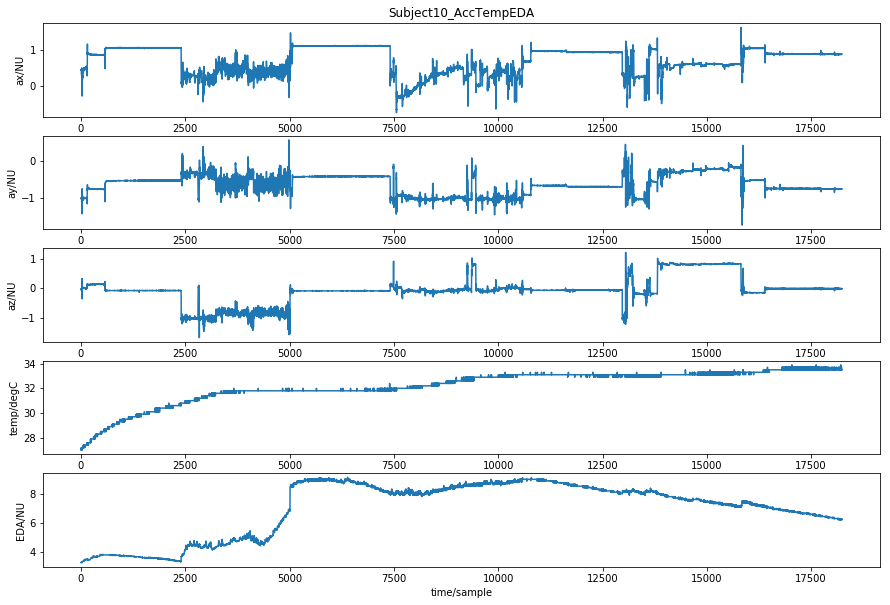

In [14]:
record = wfdb.rdrecord('./data/physionet/Subject10_AccTempEDA')
print(record.__dict__)

wfdb.plot_wfdb(record=record, title='Subject10_AccTempEDA',
              figsize=(15, 10))